In [1]:
from utils import *
from model import *
from processing import *
from train_paper import *
import argparse
import matplotlib.pyplot as plt
from evaluation import *


from sklearn.model_selection import KFold

## Set data paths for loading

In [2]:
SPLIT_1_LR_PATH = 'RandomCV/Train/Fold1/lr_split_1.csv'
SPLIT_1_HR_PATH = 'RandomCV/Train/Fold1/hr_split_1.csv'
SPLIT_2_LR_PATH = 'RandomCV/Train/Fold2/lr_split_2.csv'
SPLIT_2_HR_PATH = 'RandomCV/Train/Fold2/hr_split_2.csv'
SPLIT_3_LR_PATH = 'RandomCV/Train/Fold3/lr_split_3.csv'
SPLIT_3_HR_PATH = 'RandomCV/Train/Fold3/hr_split_3.csv'

## Set model arguments

In [3]:
class Args(argparse.Namespace):
    epochs = 500
    lr = 0.0001
    lmbda = 0.1
    lr_dim = 160
    hr_dim = 320
    hidden_dim = 640
    padding = 26
    double_convolution = True
    dropout = 0.1
    weight_decay = 0
    
args = Args()

## 3 - Fold CV

In [ ]:
# Set seeds
from sympy import fu


SEED = 42
GET_METRICS = True
torch.manual_seed(SEED)
np.random.seed(SEED)

# Load Data
split_1_adj, split_1_ground_truth = load_matrix_data(SPLIT_1_LR_PATH, SPLIT_1_HR_PATH, 93)
split_2_adj, split_2_ground_truth = load_matrix_data(SPLIT_2_LR_PATH, SPLIT_2_HR_PATH, 93)
split_3_adj, split_3_ground_truth = load_matrix_data(SPLIT_3_LR_PATH, SPLIT_3_HR_PATH, 93)

print("DATA LOADED")

fold_results = []
train_losses_all_with_val = []
val_losses_all_with_val = []
train_losses_all_no_val = []

# Run 3-fold CV
for i in range(3):
    print(f"Fold {i+1}:")
    
    # Determine train, validation, and test splits
    if i == 0:
        train_adj = torch.cat((split_2_adj[:-20], split_3_adj[:-20]), dim=0)
        train_ground_truth = torch.cat((split_2_ground_truth[:-20], split_3_ground_truth[:-20]), dim=0)
        val_adj = torch.cat((split_2_adj[-20:], split_3_adj[-20:]), dim=0)
        val_ground_truth = torch.cat((split_2_ground_truth[-20:], split_3_ground_truth[-20:]), dim=0)
        test_adj = split_1_adj
        test_ground_truth = split_1_ground_truth
    elif i == 1:
        train_adj = torch.cat((split_1_adj[:-20], split_3_adj[:-20]), dim=0)
        train_ground_truth = torch.cat((split_1_ground_truth[:-20], split_3_ground_truth[:-20]), dim=0)
        val_adj = torch.cat((split_1_adj[-20:], split_3_adj[-20:]), dim=0)
        val_ground_truth = torch.cat((split_1_ground_truth[-20:], split_3_ground_truth[-20:]), dim=0)
        test_adj = split_2_adj
        test_ground_truth = split_2_ground_truth
    else:
        train_adj = torch.cat((split_1_adj[:-20], split_2_adj[:-20]), dim=0)
        train_ground_truth = torch.cat((split_1_ground_truth[:-20], split_2_ground_truth[:-20]), dim=0)
        val_adj = torch.cat((split_1_adj[-20:], split_2_adj[-20:]), dim=0)
        val_ground_truth = torch.cat((split_1_ground_truth[-20:], split_2_ground_truth[-20:]), dim=0)
        test_adj = split_3_adj
        test_ground_truth = split_3_ground_truth
    
    # Initialize model
    model = SuperBLTGraph(args)
    
    train_labels = create_discrepancy(train_ground_truth, zero_shift=-0.05)
    
    # Train model
    train_losses, val_losses, best_epoch, lr_schedule = train(model, train_adj, train_labels, args, val_adj, val_ground_truth)
    train_losses_all_with_val.append(train_losses)
    val_losses_all_with_val.append(val_losses)

   # Retrain model on full training set (without validation)
    #full_train_adj = torch.cat((train_adj, val_adj), dim=0)
    #full_train_ground_truth = torch.cat((train_ground_truth, val_ground_truth), dim=0)
    
    #model = SuperBLTGraph(args)
    #train_labels = create_discrepancy(full_train_ground_truth, zero_shift=-0.05)

    #train_losses = retrain_model(model, full_train_adj, full_train_ground_truth, args, lr_schedule, best_epoch)
    #train_losses_all_no_val.append(train_losses)
    
    # Get metrics for the left-out fold
    test_outputs = compute_output_hr(args, test_adj, model)
    metrics = evaluate_all(test_ground_truth.detach().numpy(), test_outputs)

### Plot loss

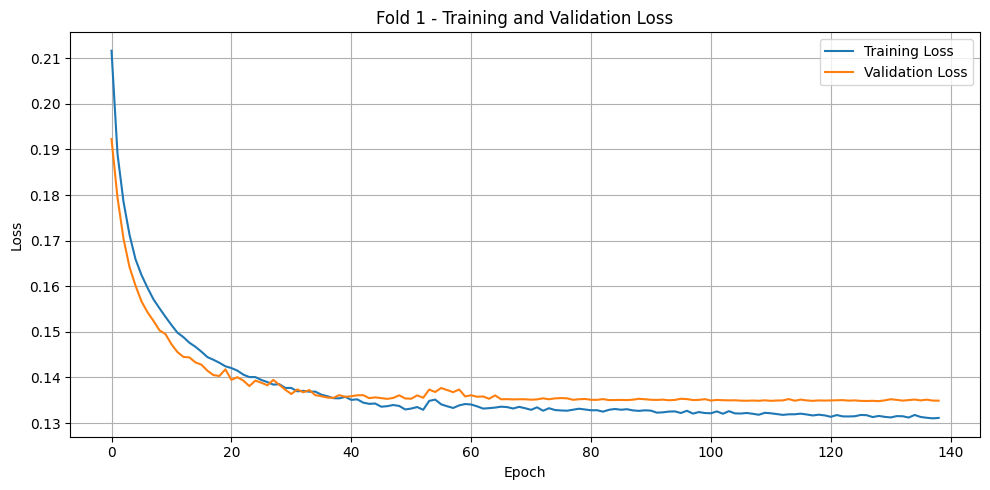

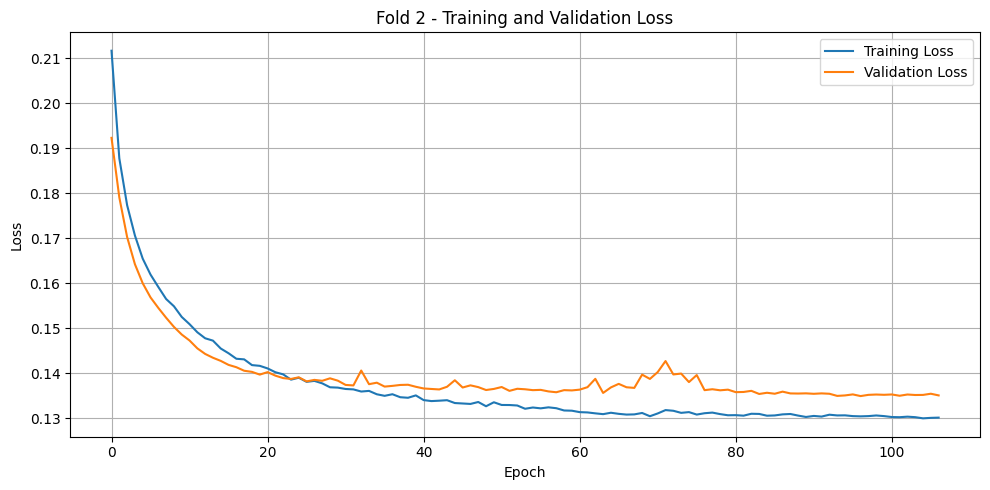

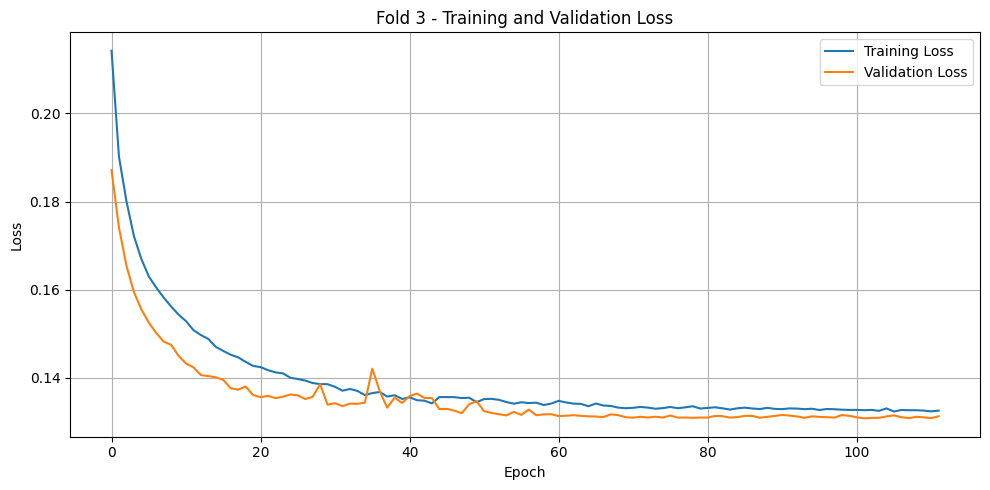

In [5]:
# Create plots for each fold
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_all_with_val[i], label='Training Loss')
    plt.plot(val_losses_all_with_val[i], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {i+1} - Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

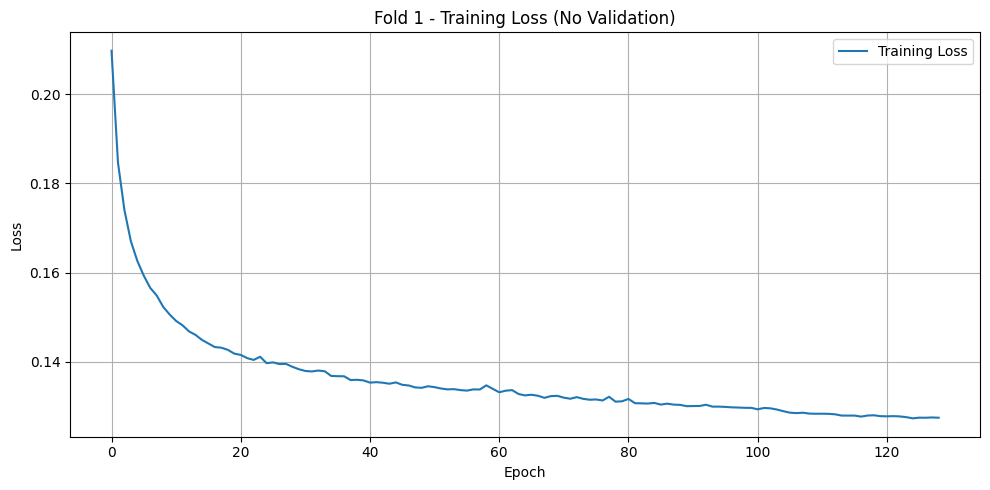

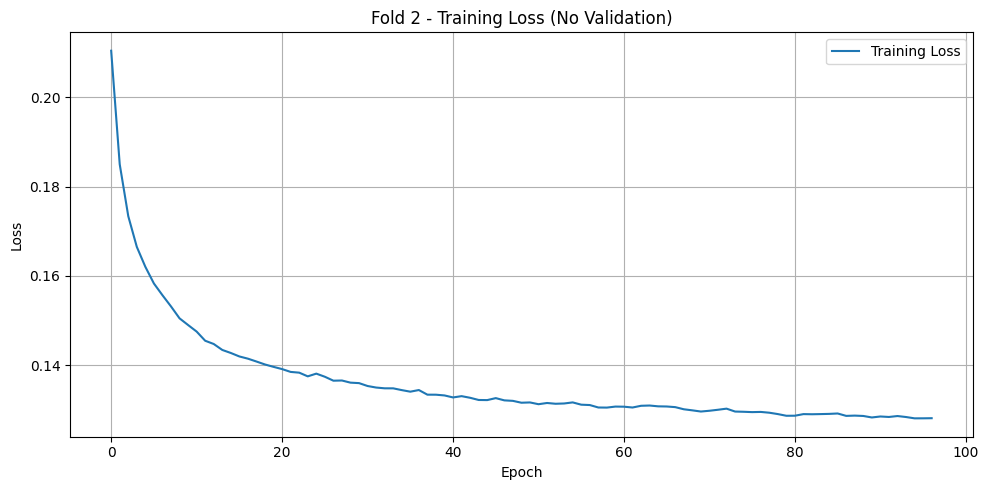

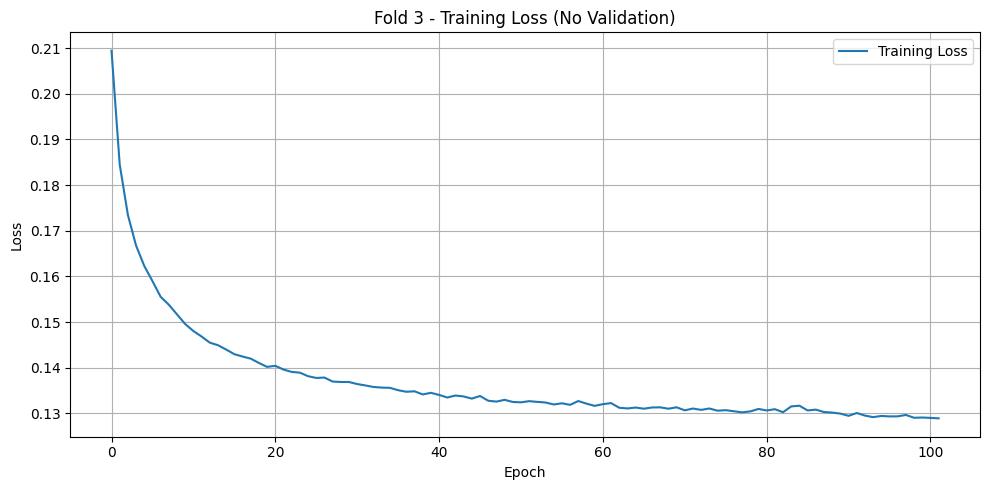

In [6]:
# Create plots for each fold
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_all_no_val[i], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {i+1} - Training Loss (No Validation)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [19]:
identity_df = pd.read_csv('ID-randomCV.csv', index_col=0, header=0)

In [20]:
identity_df

,MAE,PCC,JSD,MAE in NS,MAE in PR,MAE in EC,MAE in BC,MAE in PC,MAE in ACC
ID,,,,,,,,,
1,0.141296,0.630914,0.219973,19.007463,8.673617e-19,0.000401,0.000256,0.030325,0.046137
2,0.128115,0.642816,0.315339,46.514925,0.000000e+00,0.000665,0.000621,0.107378,0.113945
3,0.129541,0.622093,0.312396,46.186567,8.673617e-19,0.000696,0.000631,0.061417,0.115523
4,0.148305,0.609173,0.289907,41.343284,8.673617e-19,0.001470,0.000553,0.028843,0.082153
5,0.180513,0.655760,0.257302,17.611940,4.336809e-19,0.000018,0.000028,0.052001,0.006216
...,...,...,...,...,...,...,...,...,...
89,0.119925,0.649845,0.272777,32.514925,1.301043e-18,0.000229,0.000417,0.067967,0.086018
90,0.155661,0.753972,0.148709,7.425373,4.336809e-19,0.000022,0.000023,0.068199,0.000783
91,0.107305,0.694116,0.311649,48.261194,0.000000e+00,0.000392,0.000636,0.041822,0.127820


In [21]:
#add row averaging and std columns except for the first column and top row
identity_df.loc['mean'] = identity_df.mean()
identity_df.loc['std'] = identity_df.std()

In [22]:
identity_df

,MAE,PCC,JSD,MAE in NS,MAE in PR,MAE in EC,MAE in BC,MAE in PC,MAE in ACC
ID,,,,,,,,,
1,0.141296,0.630914,0.219973,19.007463,8.673617e-19,0.000401,0.000256,0.030325,0.046137
2,0.128115,0.642816,0.315339,46.514925,0.000000e+00,0.000665,0.000621,0.107378,0.113945
3,0.129541,0.622093,0.312396,46.186567,8.673617e-19,0.000696,0.000631,0.061417,0.115523
4,0.148305,0.609173,0.289907,41.343284,8.673617e-19,0.001470,0.000553,0.028843,0.082153
5,0.180513,0.655760,0.257302,17.611940,4.336809e-19,0.000018,0.000028,0.052001,0.006216
...,...,...,...,...,...,...,...,...,...
91,0.107305,0.694116,0.311649,48.261194,0.000000e+00,0.000392,0.000636,0.041822,0.127820
92,0.317458,0.471552,0.300411,30.246269,0.000000e+00,0.000904,0.000349,0.088990,0.053178
93,0.141318,0.605513,0.246077,21.686567,0.000000e+00,0.000179,0.000244,0.011218,0.052210


In [13]:
# save the dataframe to a csv file
identity_df.to_csv('01-randomCV.csv')

# ClusterCV

## Set data paths for loading

In [2]:
SPLIT_1_LR_PATH = 'Cluster-CV/Fold1/lr_clusterA.csv'
SPLIT_1_HR_PATH = 'Cluster-CV/Fold1/hr_clusterA.csv'
SPLIT_2_LR_PATH = 'Cluster-CV/Fold2/lr_clusterB.csv'
SPLIT_2_HR_PATH = 'Cluster-CV/Fold2/hr_clusterB.csv'
SPLIT_3_LR_PATH = 'Cluster-CV/Fold3/lr_clusterC.csv'
SPLIT_3_HR_PATH = 'Cluster-CV/Fold3/hr_clusterC.csv'

## Set model arguments

In [3]:
class Args(argparse.Namespace):
    epochs = 500
    lr = 0.0001
    lmbda = 0.1
    lr_dim = 160
    hr_dim = 320
    hidden_dim = 640
    padding = 26
    double_convolution = True
    dropout = 0.1
    weight_decay = 0
    
args = Args()

## 3 - Fold CV

In [ ]:
# Set seeds
from sympy import fu


SEED = 42
GET_METRICS = True
torch.manual_seed(SEED)
np.random.seed(SEED)

# Load Data
split_1_adj, split_1_ground_truth = load_matrix_data(SPLIT_1_LR_PATH, SPLIT_1_HR_PATH, 103)
split_2_adj, split_2_ground_truth = load_matrix_data(SPLIT_2_LR_PATH, SPLIT_2_HR_PATH, 103)
split_3_adj, split_3_ground_truth = load_matrix_data(SPLIT_3_LR_PATH, SPLIT_3_HR_PATH, 76)

print("DATA LOADED")

fold_results = []
train_losses_all_with_val = []
val_losses_all_with_val = []
train_losses_all_no_val = []

# Run 3-fold CV
for i in range(3):
    print(f"Fold {i+1}:")
    
    # Determine train, validation, and test splits
    if i == 0:
        train_adj = torch.cat((split_2_adj[:-20], split_3_adj[:-20]), dim=0)
        train_ground_truth = torch.cat((split_2_ground_truth[:-20], split_3_ground_truth[:-20]), dim=0)
        val_adj = torch.cat((split_2_adj[-20:], split_3_adj[-20:]), dim=0)
        val_ground_truth = torch.cat((split_2_ground_truth[-20:], split_3_ground_truth[-20:]), dim=0)
        test_adj = split_1_adj
        test_ground_truth = split_1_ground_truth
    elif i == 1:
        train_adj = torch.cat((split_1_adj[:-20], split_3_adj[:-20]), dim=0)
        train_ground_truth = torch.cat((split_1_ground_truth[:-20], split_3_ground_truth[:-20]), dim=0)
        val_adj = torch.cat((split_1_adj[-20:], split_3_adj[-20:]), dim=0)
        val_ground_truth = torch.cat((split_1_ground_truth[-20:], split_3_ground_truth[-20:]), dim=0)
        test_adj = split_2_adj
        test_ground_truth = split_2_ground_truth
    else:
        train_adj = torch.cat((split_1_adj[:-20], split_2_adj[:-20]), dim=0)
        train_ground_truth = torch.cat((split_1_ground_truth[:-20], split_2_ground_truth[:-20]), dim=0)
        val_adj = torch.cat((split_1_adj[-20:], split_2_adj[-20:]), dim=0)
        val_ground_truth = torch.cat((split_1_ground_truth[-20:], split_2_ground_truth[-20:]), dim=0)
        test_adj = split_3_adj
        test_ground_truth = split_3_ground_truth
    
    # Initialize model
    model = SuperBLTGraph(args)
    
    train_labels = create_discrepancy(train_ground_truth, zero_shift=-0.05)
    
    # Train model
    train_losses, val_losses, best_epoch, lr_schedule = train(model, train_adj, train_labels, args, val_adj, val_ground_truth)
    train_losses_all_with_val.append(train_losses)
    val_losses_all_with_val.append(val_losses)

   # Retrain model on full training set (without validation)
    full_train_adj = torch.cat((train_adj, val_adj), dim=0)
    full_train_ground_truth = torch.cat((train_ground_truth, val_ground_truth), dim=0)
    
    model = SuperBLTGraph(args)
    train_labels = create_discrepancy(full_train_ground_truth, zero_shift=-0.05)

    train_losses = retrain_model(model, full_train_adj, full_train_ground_truth, args, lr_schedule, best_epoch)
    train_losses_all_no_val.append(train_losses)
    
    # Get metrics for the left-out fold
    test_outputs = compute_output_hr(args, test_adj, model)
    metrics = evaluate_all(test_ground_truth.detach().numpy(), test_outputs)

### Plot loss

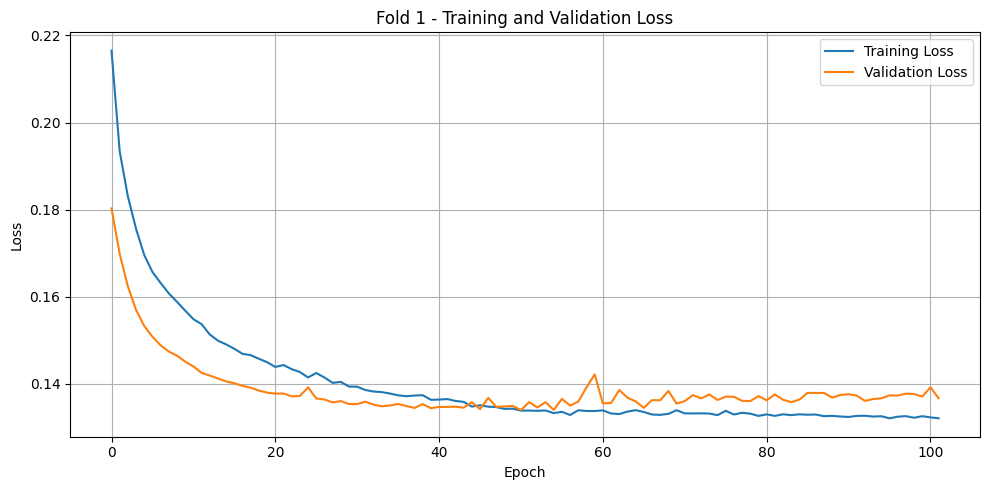

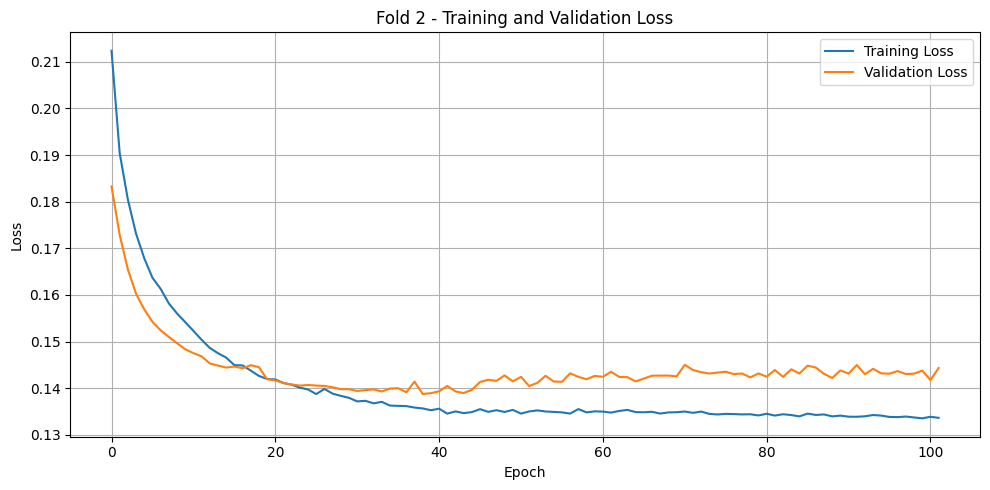

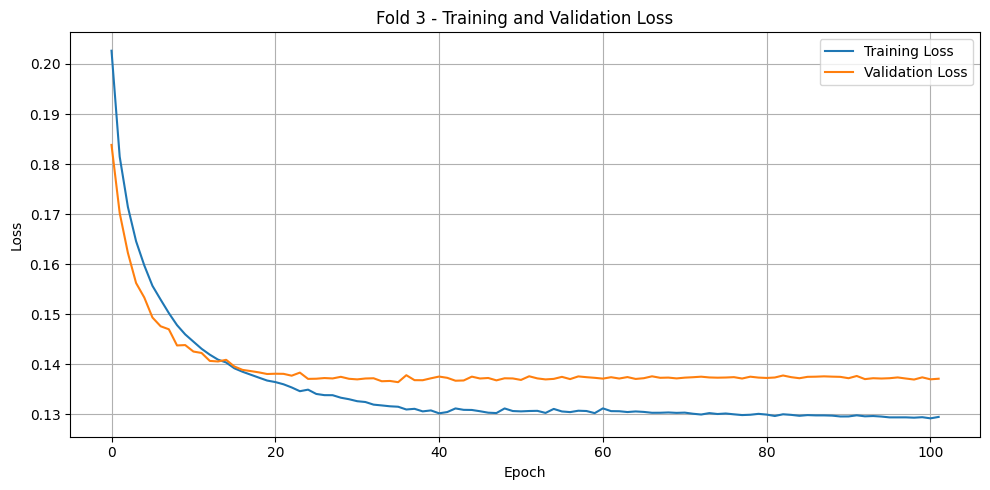

In [5]:
# Create plots for each fold
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_all_with_val[i], label='Training Loss')
    plt.plot(val_losses_all_with_val[i], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {i+1} - Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

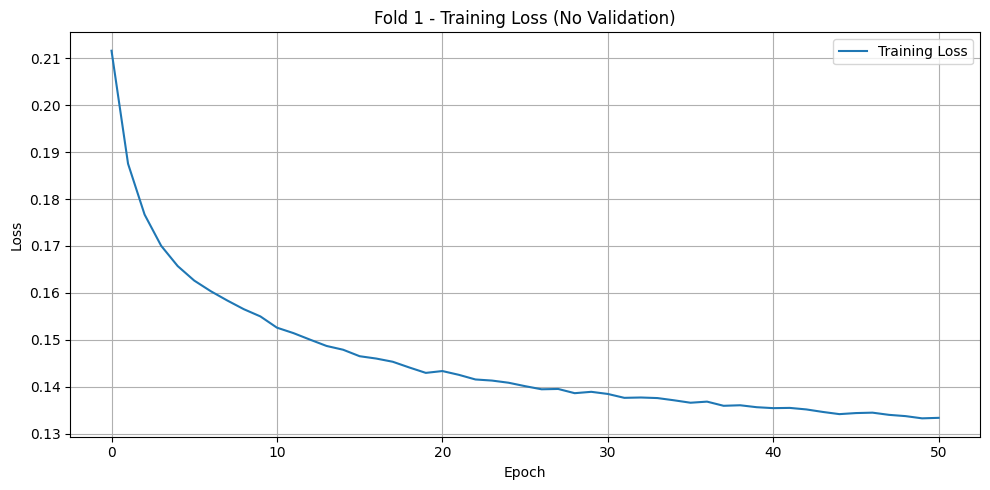

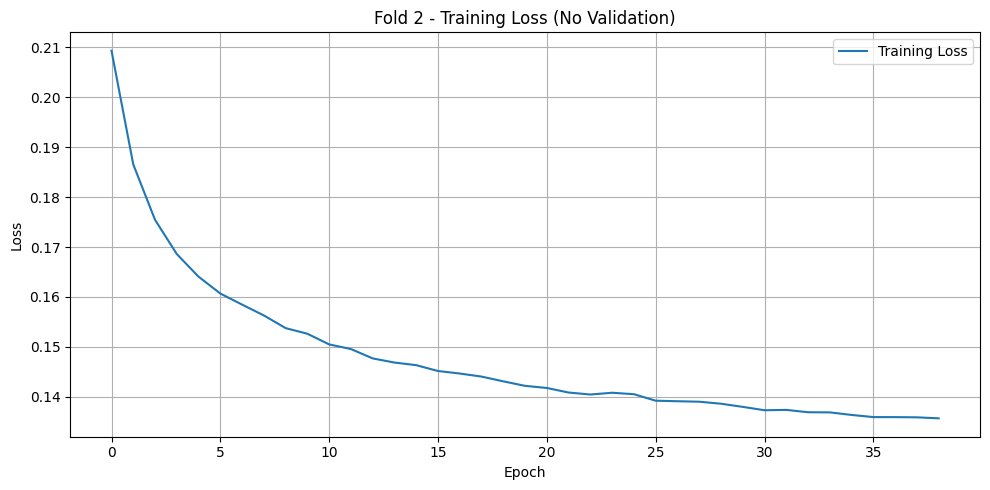

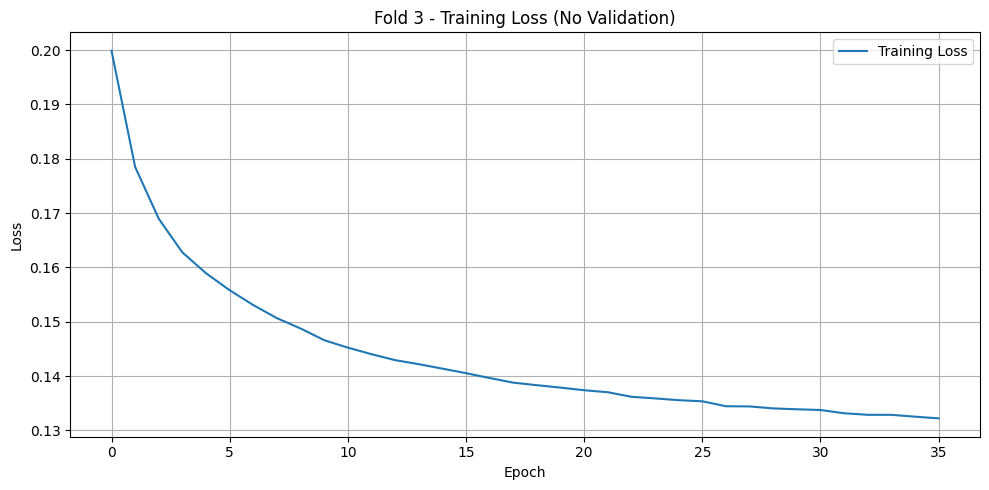

In [6]:
# Create plots for each fold
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_all_no_val[i], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {i+1} - Training Loss (No Validation)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [7]:
identity_df = pd.read_csv('ID-randomCV.csv', index_col=0, header=0)

In [8]:
identity_df

,MAE,PCC,JSD,MAE in NS,MAE in PR,MAE in EC,MAE in BC,MAE in PC,MAE in ACC
ID,,,,,,,,,
1,0.141296,0.630914,0.219973,19.007463,8.673617e-19,0.000401,0.000256,0.030325,0.046137
2,0.128115,0.642816,0.315339,46.514925,0.000000e+00,0.000665,0.000621,0.107378,0.113945
3,0.129541,0.622093,0.312396,46.186567,8.673617e-19,0.000696,0.000631,0.061417,0.115523
4,0.148305,0.609173,0.289907,41.343284,8.673617e-19,0.001470,0.000553,0.028843,0.082153
5,0.180513,0.655760,0.257302,17.611940,4.336809e-19,0.000018,0.000028,0.052001,0.006216
...,...,...,...,...,...,...,...,...,...
72,0.150510,0.562111,0.358578,66.350746,4.336809e-19,0.000870,0.000904,0.060235,0.184562
73,0.171594,0.510958,0.266393,22.291045,4.336809e-19,0.000535,0.000236,0.077658,0.036341
74,0.133605,0.624636,0.321666,58.485075,0.000000e+00,0.000695,0.000796,0.037154,0.164242


In [9]:
#add row averaging and std columns except for the first column and top row
identity_df.loc['mean'] = identity_df.mean()
identity_df.loc['std'] = identity_df.std()

In [10]:
identity_df

,MAE,PCC,JSD,MAE in NS,MAE in PR,MAE in EC,MAE in BC,MAE in PC,MAE in ACC
ID,,,,,,,,,
1,0.141296,0.630914,0.219973,19.007463,8.673617e-19,0.000401,0.000256,0.030325,0.046137
2,0.128115,0.642816,0.315339,46.514925,0.000000e+00,0.000665,0.000621,0.107378,0.113945
3,0.129541,0.622093,0.312396,46.186567,8.673617e-19,0.000696,0.000631,0.061417,0.115523
4,0.148305,0.609173,0.289907,41.343284,8.673617e-19,0.001470,0.000553,0.028843,0.082153
5,0.180513,0.655760,0.257302,17.611940,4.336809e-19,0.000018,0.000028,0.052001,0.006216
...,...,...,...,...,...,...,...,...,...
74,0.133605,0.624636,0.321666,58.485075,0.000000e+00,0.000695,0.000796,0.037154,0.164242
75,0.149883,0.614203,0.335910,64.843284,4.336809e-19,0.000947,0.000890,0.068307,0.173196
76,0.075138,NaN,NaN,172.253731,1.647987e-17,0.059193,0.001348,0.897115,0.724427


In [11]:
# save the dataframe to a csv file
identity_df.to_csv('01-clusterCV.csv')